**COMP7116001 - ASSIGNMENT 05 (SIFT Based Feature Matching)**

NIM : 2440016804

Nama : Rio Pramana

Kelas : LA01

*The explanations are in the text block and comments on the code*

**Importing libraries**

In [55]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

When we load the images that we want to match, we want to make sure that they are in the same/similar dimensions so that the accuracy can be higher

In [56]:
# Define a function that will resize the image
def resize_image(image):
    maxD = 1024
    height,width = image.shape
    aspectRatio = width/height
    if aspectRatio < 1:
        newSize = (int(maxD*aspectRatio),maxD)
    else:
        newSize = (maxD,int(maxD/aspectRatio))
    image = cv2.resize(image,newSize)
    return image

**Load the images**

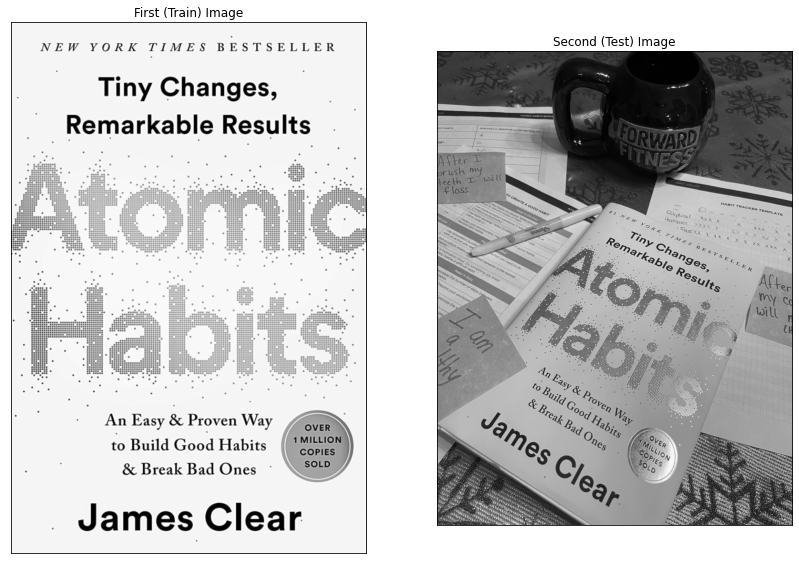

In [57]:
#Load image from files
img1 = cv2.imread('test1.jpg')
img2 = cv2.imread('test2.jpg')
# Convert the images into grayscale
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
# Resize the images
img1 = resize_image(img1)
img2 = resize_image(img2)
# Display the images
fig = plt.figure(figsize=(14,10))
# First image
plt.subplot(121),plt.imshow(img1, cmap = 'gray')
plt.title('First (Train) Image'), plt.xticks([]), plt.yticks([])
# Second image
plt.subplot(122),plt.imshow(img2, cmap = 'gray')
plt.title('Second (Test) Image'), plt.xticks([]), plt.yticks([])
plt.show()

**Finding Keypoints & Descriptors Using SIFT**

First, we need to create/instantiate a SIFT object (We are using SIFT class from opencv that is used to extract keypoints and computing descriptors using SIFT algorithm proposed by D. Lowe)

Then, we use that object to get keypoints and descriptors on both images separately

In [58]:
# Create the SIFT object
sift = cv2.SIFT_create()
# Get keypoints and descriptors for both images separately
# .detectAndCompute() is used to find keypoints and descriptors in a single step
keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

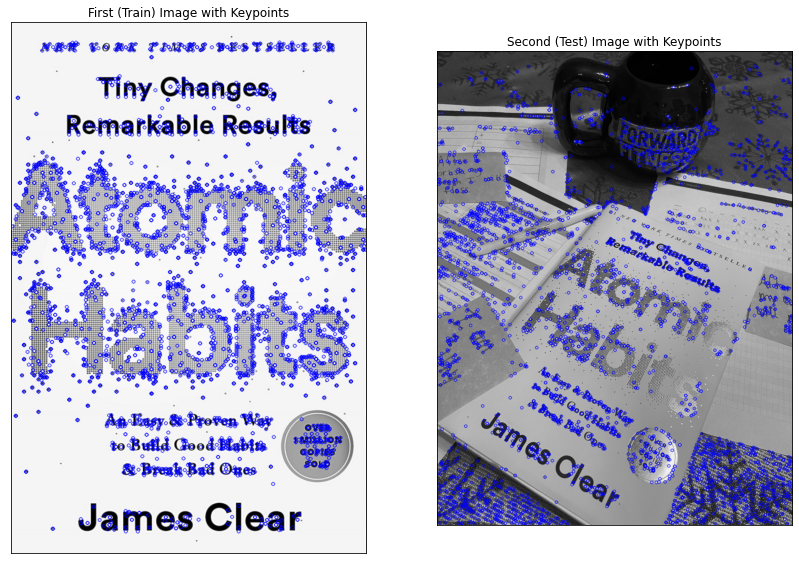

In [59]:
# Displaying both images with its keypoints
# Draw the keypoints on the image with color = blue
img1_keypoints = cv2.drawKeypoints(img1, keypoints_1, 0, (0,0,255))
img2_keypoints = cv2.drawKeypoints(img2, keypoints_2, 0, (0,0,255))
# Display
fig = plt.figure(figsize=(14,10))
# First image
plt.subplot(121),plt.imshow(img1_keypoints, cmap = 'gray')
plt.title('First (Train) Image with Keypoints'), plt.xticks([]), plt.yticks([])
# Second image
plt.subplot(122),plt.imshow(img2_keypoints, cmap = 'gray')
plt.title('Second (Test) Image with Keypoints'), plt.xticks([]), plt.yticks([])
plt.show()

**Matching the Images (Using BFMatcher)**

I will be using BFMatcher provided by opencv. The way BFMatcher (Brute-Force Matcher) works is by taking the descriptor of 1 feature in the first set and match it with every other feature in the second set using some distance calculation (like Hamming)

In [60]:
# Create the BFMatcher object
# The default distance measurement for cv2.BFMatcher() is..
# ..cv2.NORM_L2 which is a good one for SIFT
bf = cv2.BFMatcher() # Use default parameters

# Next step is to get matches from both images
bf_matches = bf.knnMatch(descriptors_1, descriptors_2, k = 2)
# It will return the 2 best matches so we can apply ratio test..
# ..proposed by D.Lowe to decide if the match we got is good enough or not

Next step is to apply ratio test by D. Lowe

It is a method to filter keypoint matches that we just got by eliminating matches that are not good enough. If the 2 best matches that we got is not different enough, then it is considered not useful enough (information-wise) and we should eliminate it.

The formula to check it is:


```
if best_match < 2nd_best_match * constant:
  the best match is a good enough match
```

In this case, I will set the constant to be 0.75 (75%)



In [61]:
# Apply ratio test
bf_good_matches1 = [] # Store the good matches
for m,n in bf_matches:
    if m.distance < (n.distance * 0.75):
        bf_good_matches1.append([m]) # Add the good match

# To make the results more accurate, we will compare the..
# ..good matches that we just got with good matches if
# ..we use knn matching of descriptors_2 with descriptors_1
bf_matches2 = bf.knnMatch(descriptors_2, descriptors_1, k=2)
# Ratio test for the second knn matching
bf_good_matches2 = []
for m,n in bf_matches2:
    if m.distance < 0.7*n.distance:
        bf_good_matches2.append([m])

# Compare both good matches and save the top results
bf_top_matches = [] # Store the top matches
for match1 in bf_good_matches1:
    match1QueryIndex = match1[0].queryIdx
    match1TrainIndex = match1[0].trainIdx
    for match2 in bf_good_matches2:
        match2QueryIndex = match2[0].queryIdx
        match2TrainIndex = match2[0].trainIdx
        if (match1QueryIndex == match2TrainIndex) and (match1TrainIndex == match2QueryIndex):
            # If the comparison met the requirement, then it is
            # ..a top match and we can add it as a result
            bf_top_matches.append(match1) # Add the match from the original knn matching

The final step is to draw the matches on the images. We will use cv.drawMatchesKnn to visualize all the best matches that we got (k = 2)


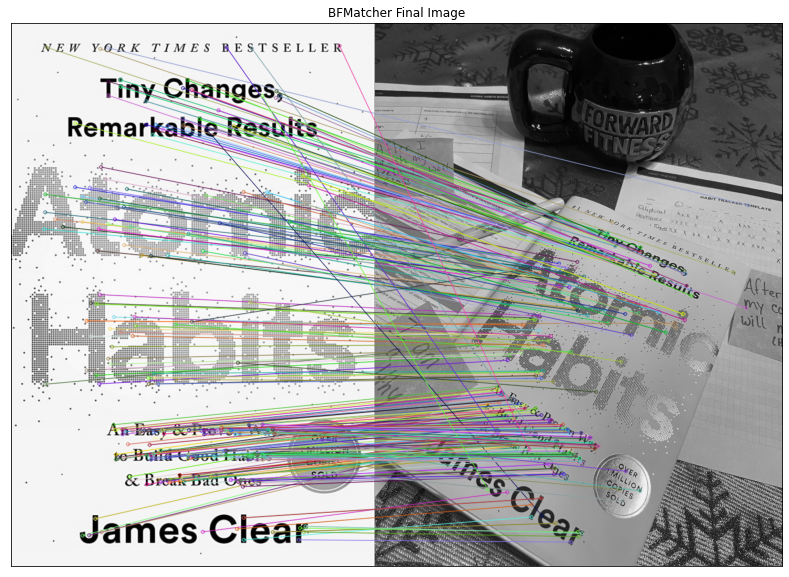

In [62]:
# Draw the matches
bf_final_img = cv2.drawMatchesKnn(
                img1, keypoints_1,
                img2, keypoints_2, 
                bf_top_matches, 
                None,
                flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
                )
# Display the image
fig = plt.figure(figsize=(14,10))
# Final image using BFMatcher
plt.imshow(bf_final_img, cmap = 'gray')
plt.title('BFMatcher Final Image'), plt.xticks([]), plt.yticks([])
plt.show()

**Matching the Images (Using FlannBasedMatcher)**

I will be using FlannBasedMatcher provided by opencv. It is said to be faster than BFMatcher when we are working with large datasets and high dimensional features

To use FLANN, we have to pass 2 dictionaries that specify the algorithm we are going to use, the parameters, etc.
They are IndexParams and SearchParams

For SIFT, we can use this for IndexParams:



In [63]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

The SearchParams specify the number of times we are going to traverse recursively through the trees in the index, the higher the better but it also takes more time

For this case, I will use this for SearchParams:

In [64]:
search_params = dict(checks = 100)

The rest of the steps are very similar with BFMatcher steps shown before

In [65]:
# Create the FLANN object using index_params and search_params
flann = cv2.FlannBasedMatcher(index_params, search_params)
# Get matches from both images
flann_matches = flann.knnMatch(descriptors_1, descriptors_2, k = 2)
# We will get 2 best matches for each keypoints so that we can..
# ..apply ratio test

We only want to get good matches, because we are using k = 2, we need to create a mask to store the good matches

In [66]:
matches_mask = [[0,0] for i in range(len(flann_matches))]

Apply ratio test with 0.75 constant

In [67]:
for i,(m,n) in enumerate(flann_matches):
    if m.distance < (n.distance * 0.75):
        matches_mask[i] = [1,0]

The final step is to draw the matches on the images. We will use cv.drawMatchesKnn

I will also create a dictionary of parameters for drawing the matches

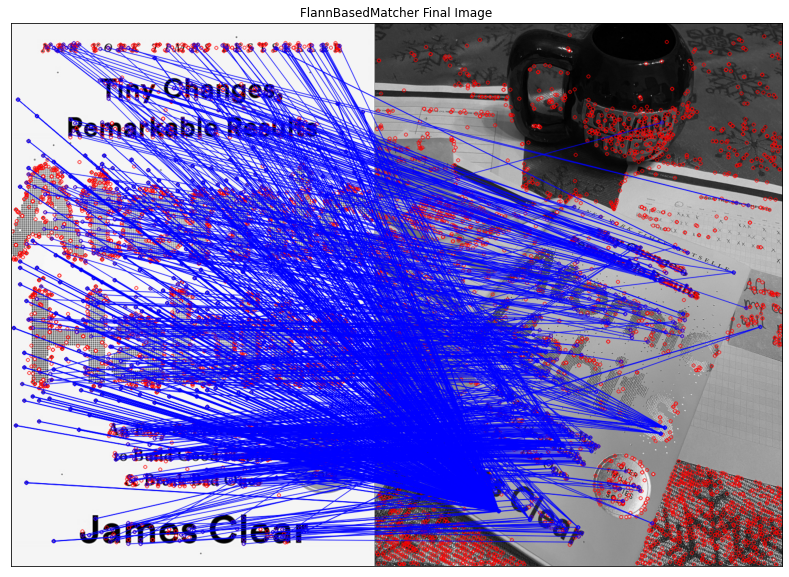

In [68]:
# Parameters for drawing the matches (colored blue)
draw_params = dict(matchColor = (0,0,255),
                   singlePointColor = (255,0,0),
                   matchesMask = matches_mask,
                   flags = cv2.DrawMatchesFlags_DEFAULT)
# Draw the matches
flann_final_img = cv2.drawMatchesKnn(img1, keypoints_1,
                                     img2, keypoints_2,
                                     flann_matches,
                                     None,
                                     **draw_params
                                    )
# Display the image
fig = plt.figure(figsize=(14,10))
# Final image using FlannBasedMatcher
plt.imshow(flann_final_img, cmap = 'gray')
plt.title('FlannBasedMatcher Final Image'), plt.xticks([]), plt.yticks([])
plt.show()

**BFMatcher & FlannBasedMatcher Final Image Side by Side Comparison**

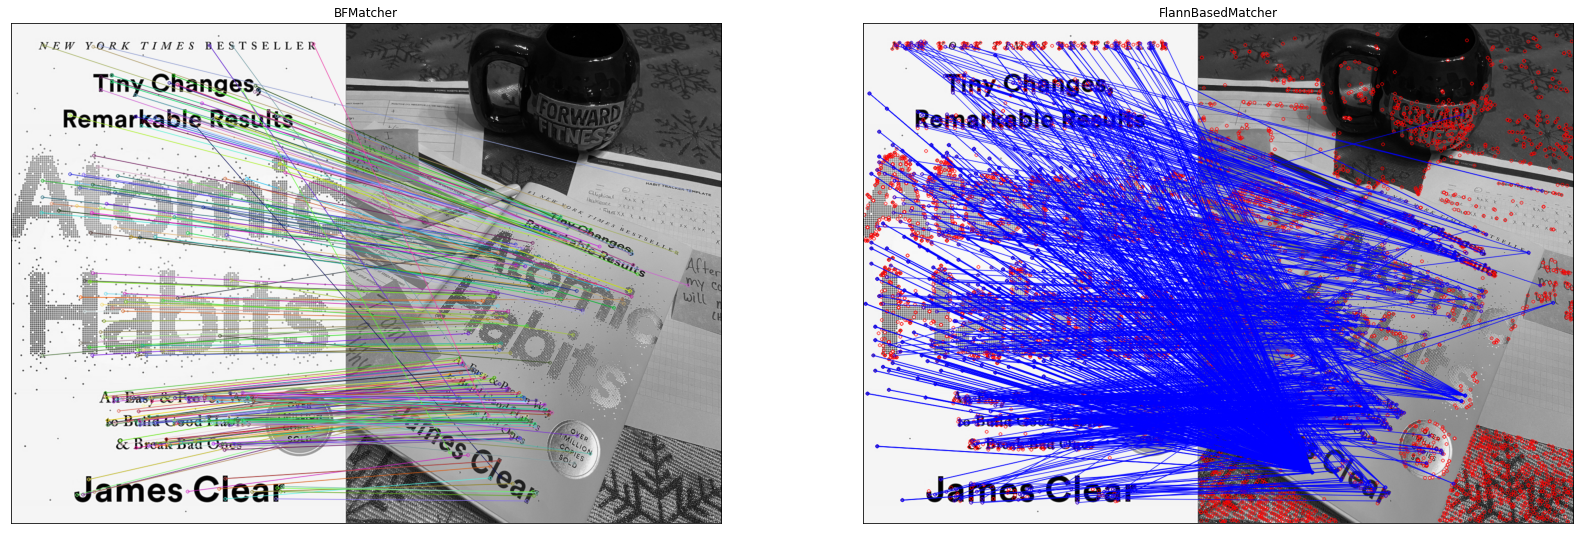

In [69]:
# Display the image
fig = plt.figure(figsize=(28,20))
# BFMatcher
plt.subplot(121),plt.imshow(bf_final_img, cmap = 'gray')
plt.title('BFMatcher'), plt.xticks([]), plt.yticks([])
# FlannBasedMatcher
plt.subplot(122),plt.imshow(flann_final_img, cmap = 'gray')
plt.title('FlannBasedMatcher'), plt.xticks([]), plt.yticks([])
plt.show()

Overall, based on the final images, it seems that BFMatcher is more accurate than FlannBasedMatcher. BFMatcher was able to find a better match while FlannBasedMatcher seems to have inaccuracies (for example, many matches were found between the sentence "New York Times Best Seller" and a random point below the author's name "James Clear")

It is maybe due to the fact that BFMatcher is a brute-force method, so it will go through every possibilities and be able to find the actual best match while FLANN relies on finding approximate nearest neighbors so it is not guaranteed to find the best match. However, FLANN is definitely faster than BFMatcher because it does not have to go through every single possibilty

I was also filtering the keypoints matches on BFMatcher technically twice, so that might also play a factor on how the BFMatcher was able to find better and cleaner matches